In [248]:
from distance_benchmark import compute_pfipf
import numpy as np
from scipy.spatial.distance import cdist

In [2]:
path_o = "../data/testing_data/output_org_osaka/"
path_r = "../data/testing_data/output_ref_osaka/"

In [3]:
o_d1 = np.load(f"{path_o}/cell_traj_d1.npy")
o_d2 = np.load(f"{path_o}/cell_traj_d2.npy")
r_d1 = np.load(f"{path_r}/cell_traj_d1.npy")
r_d2 = np.load(f"{path_r}/cell_traj_d2.npy")

In [4]:
o_d1d2 = np.concatenate([o_d1, o_d2], axis=1)
r_d1d2 = np.concatenate([r_d1, r_d2], axis=1)
assert(o_d1d2.shape == r_d1d2.shape)

In [227]:
pfipf_o = compute_pfipf(o_d1d2, max(o_d1d2.max(), r_d1d2.max()), o_d1d2.shape[0])
pfipf_r = compute_pfipf(r_d1d2, max(o_d1d2.max(), r_d1d2.max()), o_d1d2.shape[0])

In [6]:
%matplotlib notebook
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


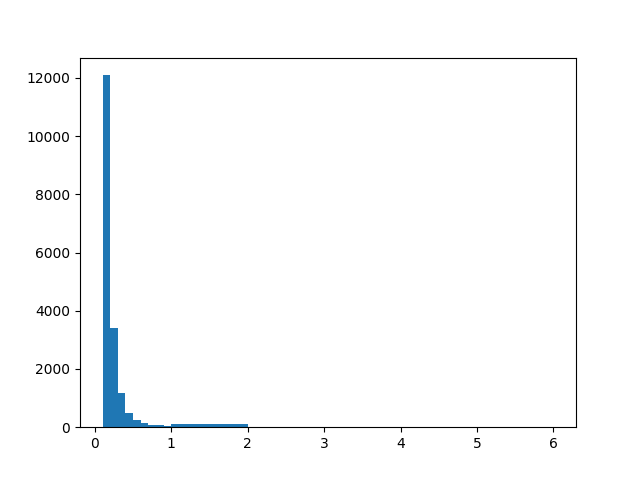

In [7]:
plt.hist(pfipf_o[pfipf_o>0].reshape(-1), bins=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6])
plt.show()

### Look for work and house

In [9]:
o_house_d1 = o_d1[:, 0]
o_house_d2 = o_d2[:, 0]

r_house_d1 = r_d1[:, 0]
r_house_d2 = r_d2[:, 0]

In [10]:
print(f"Proportion of same house between org d1 and d2: {np.count_nonzero(o_house_d1 == o_house_d2)/o_house_d1.shape[0]}")
print(f"Proportion of same house between ref d1 and d2: {np.count_nonzero(r_house_d1 == r_house_d2)/r_house_d1.shape[0]}")
print(f"Proportion of same house between org d1 and ref d1: {np.count_nonzero(o_house_d1 == r_house_d1)/o_house_d1.shape[0]}")
print(f"Proportion of same house between org d2 and ref d2: {np.count_nonzero(o_house_d2 == r_house_d2)/o_house_d1.shape[0]}")
print(f"Proportion of same house between org d2 and ref d1: {np.count_nonzero(o_house_d2 == r_house_d1)/o_house_d1.shape[0]}")
print(f"Proportion of same house between org d1 and ref d2: {np.count_nonzero(o_house_d1 == r_house_d2)/o_house_d1.shape[0]}")

Proportion of same house between org d1 and d2: 0.3775
Proportion of same house between ref d1 and d2: 0.3625
Proportion of same house between org d1 and ref d1: 0.364
Proportion of same house between org d2 and ref d2: 0.3645
Proportion of same house between org d2 and ref d1: 0.365
Proportion of same house between org d1 and ref d2: 0.355


Are most of the house that are the same, the same between days ?

In [11]:
o_houses = np.nonzero(o_house_d1 == o_house_d2)[0]

In [12]:
r_houses = np.nonzero(r_house_d1 == r_house_d2)[0]

In [13]:
np.intersect1d(o_houses, r_houses).shape[0]/o_house_d1.shape[0]

0.169

### PF-IPF of home only 

In [14]:
o_pfipf_home = o_d1d2[:, [0,1,20,21]]
r_pfipf_home = r_d1d2[:, [0,1,20,21]]

In [15]:
o_pfipf_home = compute_pfipf(o_pfipf_home, max(o_pfipf_home.max(), r_pfipf_home.max()), o_pfipf_home.shape[0])
r_pfipf_home = compute_pfipf(r_pfipf_home, max(o_pfipf_home.max(), r_pfipf_home.max()), r_pfipf_home.shape[0])

In [206]:
a = cdist(o_pfipf_home, r_pfipf_home, metric="cosine")

In [17]:
np.count_nonzero(a.min(axis=1) == a.diagonal())/2000

0.1395

In [225]:
b = cdist(np.round(o_pfipf_home), np.round(r_pfipf_home), metric="cosine")

In [226]:
np.count_nonzero(b.min(axis=1) == b.diagonal())/2000

0.1725

### Computing ngram

In [120]:
from nltk import ngrams
import pandas as pd

def ngram_visited_location(arr, n=2):

    # create ngrams array
    r = np.apply_along_axis(ngrams, 1, arr, n)
    
    for i in range(r.shape[0]):
        r[i] = np.array(list(r[i]))
        
    r = np.array(list(r))
    r = r.astype(str)
    r_str = np.zeros((r.shape[0], r.shape[1])).astype(str)
    
    for i in range(r.shape[0]):
        r_str[i] = np.apply_along_axis("+".join, 1, r[i])
        
    return r_str

In [133]:
from numba import njit


def normalize_ngrams(r_str, mapping):
        # map ngram to value between 0 and |ngrams|
    df = pd.DataFrame(r_str)
    df = df.reset_index().melt("index").sort_values(["index", "variable"])
    ngram_info = pd.DataFrame(np.unique(mapping), columns=["value"]).sort_values("value")
    ngram_info.reset_index(inplace=True)
    ngram_info.columns = ["map", "value"]
    df = df.merge(ngram_info, on="value")
    
    return np.array(df.sort_values(["index", "variable"]).drop(["value"], axis=1).pivot(index="index",columns="variable"))

In [220]:
o_ngram_d1 = ngram_visited_location(o_d1d2, 2)
r_ngram_d1 = ngram_visited_location(r_d1d2, 2)

# keep only intersection, so it's meaningfull
interect = np.intersect1d(np.unique(o_ngram_d1), np.unique(r_ngram_d1))

# only when they have the same value are conserved
o_ngram_norm_d1 = np.nan_to_num(normalize_ngrams(o_ngram_d1, interect), nan=np.unique(interect).shape[0])
r_ngram_norm_d1 = np.nan_to_num(normalize_ngrams(r_ngram_d1, interect), nan=np.unique(interect).shape[0])

In [221]:
o_pfipf_ngram = compute_pfipf(o_ngram_norm_d1.astype(int), int(o_ngram_norm_d1.max()), o_ngram_norm_d1.shape[0])
r_pfipf_ngram = compute_pfipf(r_ngram_norm_d1.astype(int), int(r_ngram_norm_d1.max()), r_ngram_norm_d1.shape[0])

# remove nan
o_pfipf_ngram = o_pfipf_ngram[:, :-1]
r_pfipf_ngram = r_pfipf_ngram[:, :-1]

In [222]:
a = cdist(o_pfipf_ngram, r_pfipf_ngram, metric="cosine")

In [224]:
np.count_nonzero(a.diagonal() == a.min(axis=1))

0.061